In [ ]:
# gsarma and travs 5/2015
# Doing some hello world testing with sciunit
# notebook from rgerkin
# http://nbviewer.ipython.org/github/scidash/neuronunit/blob/master/scratch.ipynb

## Basic sciunit examples

In [1]:
import sciunit, sciunit.capabilities, sciunit.models, sciunit.scores

In [6]:
class EqualsTest(sciunit.Test):
    """Produces a boolean score if the model predicts 
    the same number as the observation."""   
    required_capabilities = (sciunit.capabilities.ProducesNumber,)
    
    def generate_prediction(self, model):
        return model.produce_number()
    
    score_type = sciunit.scores.BooleanScore
    def compute_score(self, observation, prediction):
        return self.score_type(observation == prediction)

In [7]:
equals_one_test = EqualsTest(1)
equals_two_test = EqualsTest(2)
print equals_one_test, equals_two_test

EqualsTest (EqualsTest) EqualsTest (EqualsTest)


In [8]:
one_model = sciunit.models.ConstModel(1)
two_model = sciunit.models.ConstModel(2)
three_model = sciunit.models.ConstModel(3)
print one_model, two_model, three_model

ConstModel({'constant': 1}) ConstModel({'constant': 2}) ConstModel({'constant': 3})


In [9]:
one_one_score = equals_one_test.judge(one_model)
one_two_score = equals_two_test.judge(one_model)
print one_one_score, one_two_score

Pass Fail


In [10]:
print one_one_score.model, one_one_score.test

ConstModel({'constant': 1}) EqualsTest (EqualsTest)


In [11]:
suite = sciunit.TestSuite("suite", [equals_one_test, equals_two_test])

In [12]:
matrix = suite.judge([one_model, two_model, three_model])
print matrix[equals_one_test]
print matrix[two_model]

(Pass, Fail, Fail)
(Fail, Pass)


In [13]:
matrix.view()

,EqualsTest (EqualsTest),EqualsTest (EqualsTest)
ConstModel({'constant': 1}),Pass,Fail
ConstModel({'constant': 2}),Fail,Pass
ConstModel({'constant': 3}),Fail,Fail


## Misc jnml things

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from nml.jnml import *

ImportError: No module named nml.jnml

In [1]:
run nml/jnml



Checking channel k_fast
Written generated LEMS file to LEMS_Test_k_fast.xml

Parsing and resolving model: LEMS_Test_k_fast.xml
Building simulation
Running simulation
Processing results
Going to save 4001x1 data points to file k_fast.rampV.lems.dat
Going to save 4001x1 data points to file i_65.lems.dat
Going to save 4001x1 data points to file k_fast.p.tau.lems.dat
Going to save 4001x1 data points to file k_fast.q.tau.lems.dat
Going to save 4001x1 data points to file k_fast.p.inf.lems.dat
Going to save 4001x1 data points to file i_55.lems.dat
Going to save 4001x1 data points to file k_fast.q.inf.lems.dat
Going to save 4001x1 data points to file i_75.lems.dat


In [169]:
cols = load_dat('i_65.lems')

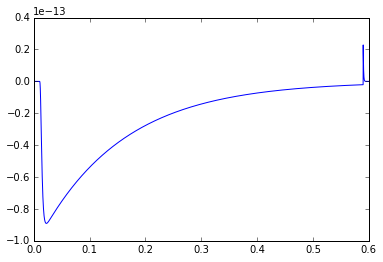

In [170]:
plt.plot(cols[0],cols[1])

In [190]:
muscle_model_xml = os.path.join(OPENWORM_HOME,'muscle_model/NeuroML2/LEMS_NeuronMuscle.xml')
ca_boyle_nml = os.path.join(OPENWORM_HOME,'muscle_model/NeuroML2/ca_boyle.channel.nml')

In [137]:
run_lems(muscle_model_xml)

["b' jNeuroML v0.5.2",
 'Loading: /Users/rgerkin/Dropbox/dev/muscle_model/NeuroML2/LEMS_NeuronMuscle.xml with jLEMS, NO GUI mode...',
 'INFO Jan 28,2015 16:27  (INFO) Reading from: /Users/rgerkin/Dropbox/dev/muscle_model/NeuroML2/LEMS_NeuronMuscle.xml',
 'WARNING Jan 28,2015 16:27  (WARNING) No internal variable is linked to the exposure: iDensity for ComponentType channelDensityNonUniform at: org.lemsml.jlems.core.type.dynamics.Dynamics.realResolve(Dynamics.java:270)',
 'WARNING Jan 28,2015 16:27  (WARNING) No internal variable is linked to the exposure: iDensity for ComponentType channelDensityNonUniformNernst at: ',
 'WARNING Jan 28,2015 16:27  (WARNING) Unused attribute in Component(id=CaPool type=fixedFactorConcentrationModel): XMLAttribute(ion, ca)  at: org.lemsml.jlems.core.type.Component.resolve(Component.java:502)',
 'INFO Jan 28,2015 16:27  (INFO) Optional path variable is absent PathDerivedVariable{varname=rateScale, path=q10Settings/q10,  func=multiply, tgtvar=q10}',
 'INFO

In [171]:
cols = load_dat('nm_v')

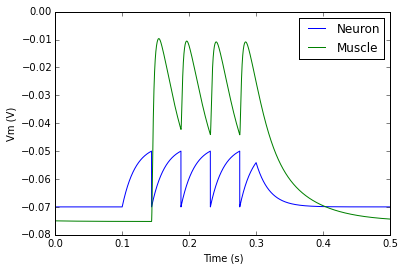

In [179]:
plt.plot(cols[0],cols[1],label='Neuron')
plt.plot(cols[0],cols[2],label='Muscle')
plt.xlabel('Time (s)')
plt.ylabel('Vm (V)')
plt.legend()

In [226]:
run_nml(ca_boyle_nml,'NML2ChannelAnalyse',channelId='ca_boyle',
        temperature=34,
        minV=-55,
        maxV=80,
        duration=600,
        clampBaseVoltage=-55,
        clampDuration=580,
        stepTargetVoltage=10,
        erev=50,
        caConc=0.001)

Checking channel ca_boyle
Written generated LEMS file to LEMS_Test_ca_boyle.xml

Ran LEMS file LEMS_Test_ca_boyle.xml


In [227]:
ls i*.dat

i_15.lems.dat     i_5.lems.dat      i_min15.lems.dat  i_min5.lems.dat
i_25.lems.dat     i_55.lems.dat     i_min25.lems.dat  i_min55.lems.dat
i_35.lems.dat     i_65.lems.dat     i_min35.lems.dat
i_45.lems.dat     i_75.lems.dat     i_min45.lems.dat


In [182]:
from BlueBrainProjectShowcase.Channelpedia import iv_analyse

In [228]:
v,_,_,i_peak = iv_analyse.main(plot=False)

voltage (mV)   i_lowest (A)   i_highest (A)   i_peak (A)
         -55   1.695952E-19   1.695952E-19   1.695952E-19
         -45   5.641766E-20   5.690491E-18   5.690491E-18
         -35   3.186363E-20   1.099339E-16   1.099339E-16
         -25   2.333611E-20   1.815811E-15   1.815811E-15
         -15   2.501452E-20   2.392100E-14   2.392100E-14
          -5   5.160191E-20   1.712388E-13   1.712388E-13
           5   7.328298E-21   4.449544E-13   4.449544E-13
          15   2.845650E-22   5.873982E-13   5.873982E-13
          25   1.797050E-24   3.912675E-13   3.912675E-13
          35   6.681011E-24   2.401117E-13   2.401117E-13
          45   3.009079E-24   8.044969E-14   8.044969E-14
          55  -8.054445E-14   1.807896E-14  -8.054445E-14
          65  -2.416984E-13   1.639105E-14  -2.416984E-13
          75  -4.028553E-13   1.615943E-14  -4.028553E-13


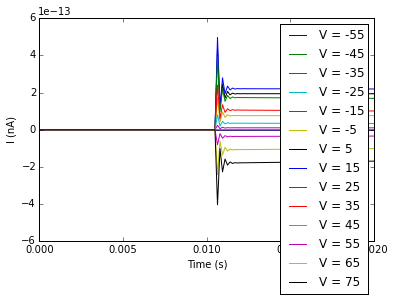

In [240]:
Vs = np.arange(-55,85,10)
for V in Vs:
    file_name = ('i_%d.lems' % V).replace('-','min')
    cols = load_dat(file_name)
    plt.plot(cols[0],cols[1],label='V = %d' % V)
plt.xlabel('Time (s)')
plt.ylabel('I (nA)')
plt.xlim(0,0.02)
plt.legend()

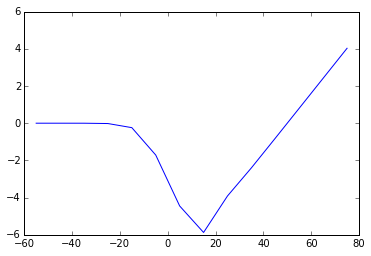

In [241]:
capacitance = 1e-13
plt.plot(v,-np.array(i_peak)/capacitance)